# Options Pricing with Black Scholes

**Defining the components of the Black Scholes equation.**

In [ ]:
def covariance(sigma1,sigma2):
    return sqrt(sigma1**2-2*sigma1*sigma2+sigma2**2)

def d1(S1,S2,T,r,sigma1,sigma2):
    return (log(S1/S2)+(r+(covariance(sigma1,sigma2)**2)/2.)*T)/(covariance(sigma1,sigma2)*sqrt(T))

def d2(S1,S2,T,r,sigma1,sigma2):
    return (log(S1/S2)+(r-(covariance(sigma1,sigma2)**2)/2.)*T)/(covariance(sigma1,sigma2)*sqrt(T))

def bs_call(S1,S2,T,r,sigma1,sigma2):
    return S1 * norm.cdf(d1(S1,S2,T,r,sigma1,sigma2)) - S2 * exp(-r * T) * norm.cdf(d2(S1,S2,T,r,sigma1,sigma2))

def bs_put(S1,S2,T,r,sigma1,sigma2):
    return S2 * exp(-r * T) - S1 + bs_call(S1,S2,T,r,sigma1,sigma2)

**Extract share price data from Yahoo Finance**

In [ ]:
today = datetime.now()
one_year_ago = today.replace(year=today.year-1)
expiry = '02-25-2021'

In [ ]:
stock1 = 'AAPL'

In [ ]:
dfone = web.DataReader(stock1, 'yahoo', one_year_ago, today)

In [ ]:
dfone = dfone.sort_values(by="Date")
dfone = dfone.dropna()
dfone = dfone.assign(close_day_before=dfone.Close.shift(1))
dfone['returns'] = ((dfone.Close - dfone.close_day_before)/dfone.close_day_before)

In [ ]:
sigma1 = np.sqrt(252) * dfone['returns'].std()
lcp1 = dfone['Close'].iloc[-1]

In [ ]:
stock2 = 'GE'

In [ ]:
dftwo = web.DataReader(stock2, 'yahoo', one_year_ago, today)

In [ ]:
dftwo = dftwo.sort_values(by="Date")
dftwo = dftwo.dropna()
dftwo = dftwo.assign(close_day_before=dftwo.Close.shift(1))
dftwo['returns'] = ((dftwo.Close - dftwo.close_day_before)/dftwo.close_day_before)

In [ ]:
sigma2 = np.sqrt(252) * dftwo['returns'].std()
lcp2 = dftwo['Close'].iloc[-1]

In [ ]:
uty = web.DataReader(
    "^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1]
t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365

In [ ]:
print('The Option Price is: ', bs_call(lcp1, lcp2, t, uty, sigma1, sigma2))

In [ ]:
!pip install opstrat

In [ ]:
import opstrat as op

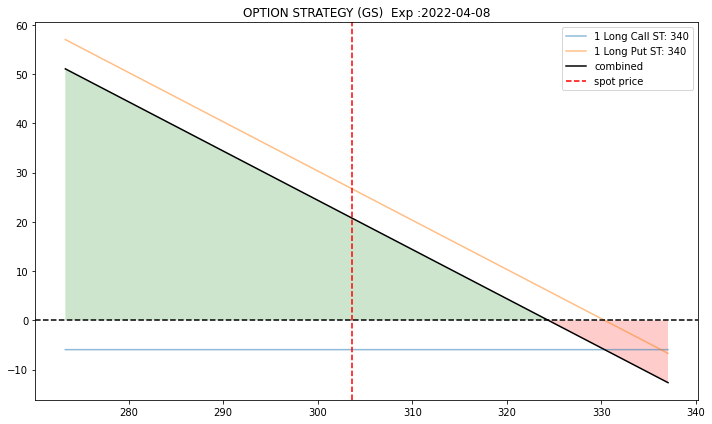

In [ ]:
op_1 = {'op_type': 'c', 'strike':340, 'tr_type': 'b'}
op_2 = {'op_type': 'p', 'strike':340, 'tr_type': 'b'}

op.yf_plotter(ticker='GS', exp='2022-04-08', 
              op_list=[op_1, op_2])

# Portfolio with Options / Dynamic Hedging

As we saw from the derivation and the actual Black Scholes model, the partial derivative can tell us how the option value changes when one of these exposures changes holding the others constant.

In this example we have a short position in 1000 stock calls, we want to hedge our exposure to changes in volatility, movements in the underlying asset, and the speed of movements in the underlying asset.

In [ ]:
import math
from scipy.stats import norm

Delta: the first-order partial-derivative with respect to the underlying asset of the Black-Scholes equation is known as delta. Delta refers to how the option value changes when there is a change in the underlying asset price. 

Gamma: the second-order partial-derivative with respect to the underlying asset of the Black-Scholes equation is known as gamma. Gamma refers to how the option’s delta changes when there is a change in the underlying asset price.

Vega: The first-order partial-derivative with respect to the underlying asset volatility of the Black-Scholes equation is known as vega. Vega refers to how the option value changes when there is a change in the underlying asset volatility.

In [ ]:
class EuropeanCall:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1

    def call_gamma(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = z1/(asset_price*asset_volatility*math.sqrt(time_to_expiration))
        return z2

    def call_vega(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = asset_price*z1*math.sqrt(time_to_expiration)
        return z2/100

    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.gamma = self.call_gamma(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.vega = self.call_vega(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [ ]:
class EuropeanPut:

    def put_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1 - 1

    def put_gamma(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = z1/(asset_price*asset_volatility*math.sqrt(time_to_expiration))
        return z2

    def put_vega(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = asset_price*z1*math.sqrt(time_to_expiration)
        return z2/100

    def put_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log((b*strike_price)/asset_price) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = b*strike_price*z1
        x2 = math.log((b*strike_price)/asset_price) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = asset_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.put_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.put_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.gamma = self.put_gamma(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.vega = self.put_vega(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [ ]:
short = EuropeanCall(543, .53, 545, 30/365, .015)
print(short.delta*(-1000))
print(short.gamma*(-1000))
print(short.vega*(-1000))

In [ ]:
call_a = EuropeanCall(543, .53, 550, 30/365, .015)
print(call_a.delta)
print(call_a.gamma)
print(call_a.vega)

call_b = EuropeanCall(543, .53, 555, 30/365, .015)
print(call_b.delta)
print(call_b.gamma)
print(call_b.vega)

**Underlying Asset (NVDA Stock):
Delta: 1
Gamma: 0
Vega: 0**

Using a combination of these assets we can neutralize our portfolio’s exposure to delta, gamma, and vega.

In [ ]:
greeks = np.array([[call_a.gamma, call_b.gamma], [call_a.vega, call_b.vega]])
portfolio_greeks = [[short.gamma*1000], [short.vega*1000]]

# We need to round otherwise we can end up with a non-invertible matrix
inv = np.linalg.inv(np.round(greeks, 2))
print(inv)

In [ ]:
w = np.dot(inv, portfolio_greeks)
print(w)

Using these weights we will have effectively neutralized our exposure to gamma and vega…

In [ ]:
print(np.round(np.dot(np.round(greeks, 2), w) - portfolio_greeks))

To find our new exposure, we take the sum-product of all option positions in our portfolio with their respective deltas.

In [ ]:
# Greeks including delta
portfolio_greeks = [[short_nvda.delta*-1000], [short_nvda.gamma*-1000], [short_nvda.vega*-1000]]
greeks = np.array([[call_a.delta, call_b.delta], [call_a.gamma, call_b.gamma], [call_a.vega, call_b.vega]])
print(np.round(np.dot(np.round(greeks, 2), w) + portfolio_greeks))